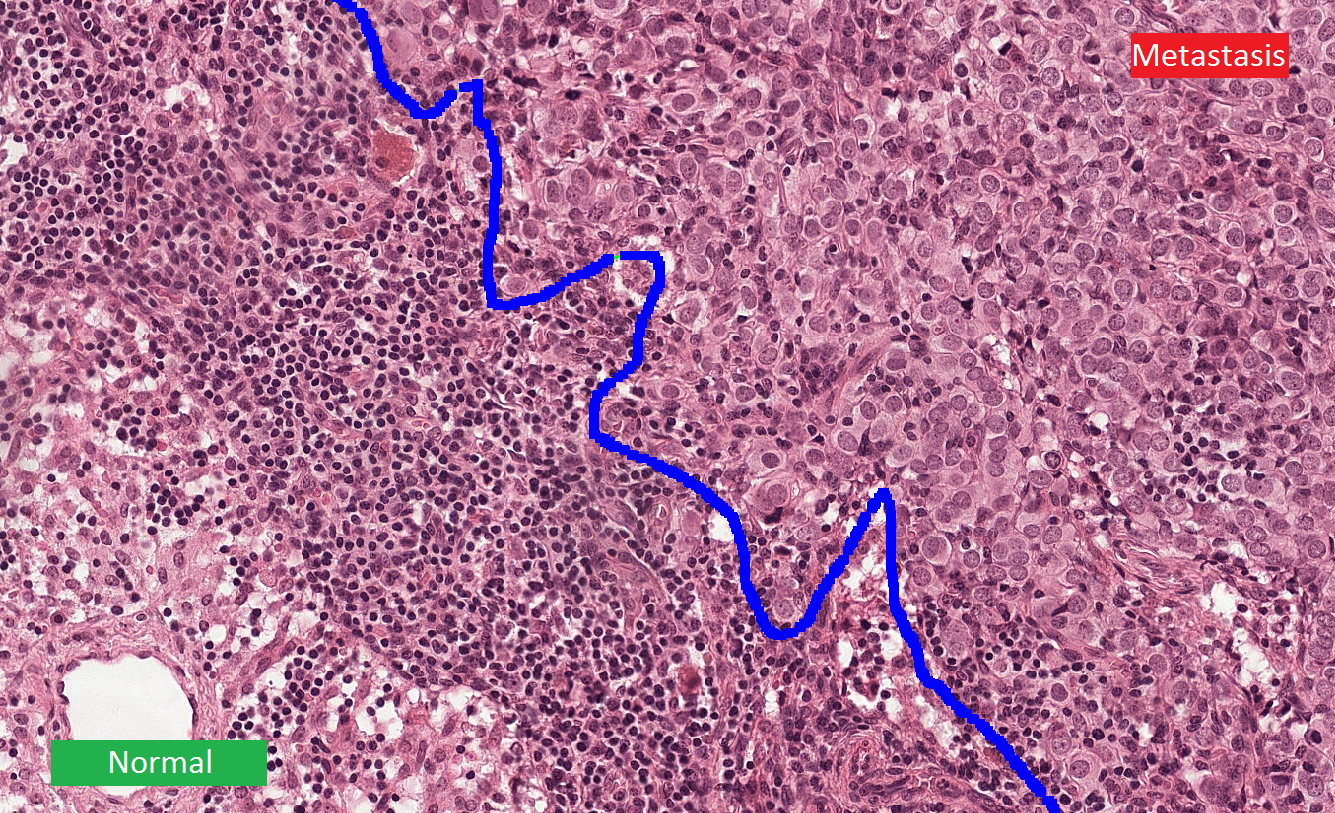

# Camelyon
The goal of this challenge is to evaluate new and existing algorithms for automated detection of metastases in hematoxylin and eosin (H&E) stained whole-slide images of lymph node sections([website](https://camelyon16.grand-challenge.org/Home/)). This task has a high clinical relevance but requires large amounts of reading time from pathologists.
The first training dataset consists of 170 WSIs of lymph node (100 Normal and 70 containing metastases) and the second 100 WSIs (including 60 normal slides and 40 slides containing metastases). The test dataset consists of 130 WSIs which are collected from both Universities. WSIs Pre-processing. We remove background patches through an approach
similar to the one presented in the CLAM framework: after an initial segmentation process based on Otsu non-overlapped patches within the foreground regions are considered. The representations yield by DINO provide a detailed description of the local patterns in each patch; For more information about the dataset and preprocessing read [Dataset](https://camelyon16.grand-challenge.org/Data/) and [DASMIL repo](https://github.com/aimagelab/mil4wsi)

In [ ]:
# @title Download Camelyon16 embeddings
# @markdown This code is designed to download and extract a dataset called "Camelyon16 embeddings".
!curl -o dataset.zip https://ailb-web.ing.unimore.it/publicfiles/miccai_dasmil_checkpoints/cam_feats.zip
!unzip dataset.zip

In [ ]:
# @title Prepare Environment
# @markdown This section of code is primarily focused on setting up the necessary environment for a machine learning project, likely involving PyTorch and related libraries.
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install nystrom-attention
!pip install wandb
!git clone https://github.com/aimagelab/mil4wsi.git
!cd mil4wsi

In [ ]:
# @title Load Libraries
# @markdown This code snippet is dedicated to importing necessary libraries and modules that will be used in the rest of the program.

Loading Libraries and Modules
This code snippet is dedicated to importing necessary libraries and modules that will be used in the rest of the program.
from torch_geometric.data import Dataset
import glob
from torch_geometric.data import data
from torch_geometric.loader import DataLoader
import sys
sys.path.append("/content/mil4wsi")
from utilsmil4wsi.test import test
import argparse
from models import selectModel
import wandb
from torch.nn import BCEWithLogitsLoss
import torch
import os
import wandb
from argparse import Namespace
import time
import tqdm

In [ ]:
data_root="camGraph_23/processed"

In [ ]:
# @title Dataset
# @markdown This code defines a custom dataset class called CustomDataset which inherits from the Dataset class from the torch_geometric.data module. This class is important to iterate over WSIs.
# @markdown Train and Test split follow the same split of the challenge.
class CustomDataset(Dataset):
    def __init__(self,root,data_type):
        self.path=os.path.join(root,data_type,"*")
        self.data=glob.glob(self.path)
        print(self.data)
        self.slides=[torch.load(self.data[idx]) for idx in range(len(self.data))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.slides[idx]
        return sample
train_dataset=CustomDataset(data_root,"train")
test_dataset=CustomDataset(data_root,"test")
train_loader=DataLoader(train_dataset,batch_size=1,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False)

In [ ]:
# @title General Parser
# @markdown This function, get_args(), is designed to handle command-line arguments or parameters for the program. It uses the argparse module to define, parse, and organize these arguments into a structured format.
# @markdown Common hyperparameters shared  between models: lr(learning rate),weight_decay,seed,n_epoch,n_classes,input_size.
# @markdown lr (Learning Rate): Determines the step size at each iteration while moving toward a minimum of the loss function. It controls how quickly the model learns. weight_decay:
# @markdown A regularization parameter that prevents overfitting by penalizing large weights in the model.
# @markdown seed: Sets the random seed for reproducibility, ensuring that experiments yield consistent results across different runs.
# @markdown n_epoch: Specifies the number of training epochs, i.e., how many times the model will iterate over the entire dataset.
# @markdown n_classes: Indicates the number of target classes in the classification problem, defining the output layer's size.
# @markdown input_size: Refers to the dimensionality or size of the input data expected by the model.

def get_args():
    parser = argparse.ArgumentParser(description='hyperparameters')

    # Optimization arguments
    group1 = parser.add_argument_group("optimization")
    group1.add_argument('--lr', default=0.0002,
                        type=float, help='learning rate')
    group1.add_argument('--weight_decay', default=0.00001,
                        type=float, help='Weight decay [5e-3]')

    # GNN arguments
    group2 = parser.add_argument_group("gnn")
    group2.add_argument('--residual', default=False, action="store_true",)
    group2.add_argument('--num_layers', default=1, type=int,
                        help='number of Graph layers')
    group2.add_argument('--dropout', default=True, action="store_true")
    group2.add_argument('--dropout_rate', default=0.2, type=float)
    group2.add_argument('--layer_name', default="GAT",
                        type=str, help='layer graph name')
    group2.add_argument('--heads', default=3, type=int,
                        help='layer graph name')

    # Training arguments
    group3 = parser.add_argument_group("training")
    group3.add_argument('--seed', default=12, type=int,
                        help='seed for reproducibility')
    group3.add_argument('--n_epoch', default=200,
                        type=int, help='number of epochs')

    # Dimensions arguments
    group4 = parser.add_argument_group("dimensions")
    group4.add_argument('--n_classes', default=1, type=int,
                        help='Number of output classes [2]')
    group4.add_argument('--c_hidden', default=256,
                        type=int, help='intermediate size ')
    group4.add_argument('--input_size', default=384,
                        type=int, help='input size ')

    # Dataset arguments
    group5 = parser.add_argument_group("dataset")
    group5.add_argument('--scale', default="1", type=str,
                        help='scale resolution')
    group5.add_argument('--dataset', default="cam", type=str,
                        choices=["cam", "lung"], help='input size ')
    group5.add_argument('--datasetpath',  type=str, help='dataset path')

    # Distillation arguments
    group6 = parser.add_argument_group("distillation")
    group6.add_argument('--lamb', default=1, type=float, help='lambda')
    group6.add_argument('--beta', default=1, type=float, help='beta')
    group6.add_argument('--temperature', default=1.5, type=float, help='temperature')
    group6.add_argument('--add_bias', default=True,action="store_true")
    group6.add_argument('--max', default=True,action="store_true")
    group6.add_argument('--checkpoint', default=None,type=str, help='checkpoint')

    parser.add_argument('--tag', default="split", type=str, help='train strategy')
    parser.add_argument('--modeltype', default="DSMIL", type=str, help='train strategy')
    parser.add_argument('--project', default="decider-geom", type=str, help='project name for wandb')
    parser.add_argument('--model', default="decider-geom", type=str, help='project name for wandb')
    parser.add_argument('--wandbname', default="main", type=str, help='project name for wandb')


    group7= parser.add_argument_group("submitit")
    group7.add_argument('--partition', default="prod",type=str,help='partition name')
    group7.add_argument('--time', default=120, type=float, help='job duration')
    group7.add_argument('--nodes', default=1, type=int, help='number of jobs')
    group7.add_argument('--job_name', default="dasmil",type=str,help="job name")
    group7.add_argument('--mem', default=32, type=int, help='ram requested GB')
    group7.add_argument('--job_parallel', default=10, type=int, help='number of jobs in parallel')
    group7.add_argument('--logfolder', default="logfolder", type=str, help='log folder location name')


    #buffermil parameters
    group8= parser.add_argument_group("submitit")

    group8.add_argument("--randomstore", default=False,help="ramdom sampling during the buffer storage")
    group8.add_argument("--bufferaggregate", default="mean",choices=["mean","max","diffmax"], help="type of buffer aggregation")
    group8.add_argument("--ntop", default=10, help="number of patches stored in the buffer per each image")
    group8.add_argument('--buffer_freq',default=10, type=int, help='frequency to update the buffer')
    filtered_args = [arg for arg in sys.argv if not arg.startswith('-f')]
    args = parser.parse_args(filtered_args[2:])
    return args

In [ ]:
args= get_args()
print(args)

Namespace(lr=0.0002, weight_decay=0.005, residual=False, num_layers=1, dropout=True, dropout_rate=0.2, layer_name='GAT', heads=3, seed=12, n_epoch=200, n_classes=1, c_hidden=256, input_size=384, scale='1', dataset='cam', datasetpath=None, lamb=1, beta=1, temperature=1.5, add_bias=True, max=True, checkpoint=None, tag='split', modeltype='DSMIL', project='decider-geom', model='decider-geom', wandbname='main', partition='prod', time=120, nodes=1, job_name='dasmil', mem=32, job_parallel=10, logfolder='logfolder', randomstore=False, bufferaggregate='mean', ntop=10, buffer_freq=10)


In [ ]:
# @title Select Model
# @markdown This code snippet creates an interactive dropdown menu within the Jupyter Notebook to allow the user to select a machine learning model.
# @markdown Available models: DSMIL (Dual-stream multiple instance learning network for whole slide image classification with self-supervised contrastive learning,CVPR2021),ABMIL (Attention-based Deep Multiple Instance Learning),
# @markdown Transmil: (Transformer based correlated multiple instance learning for whole slide image classification,NIPS 2021),
# @markdown Buffermil (Buffer-MIL: Robust Multi-instance Learning with a Buffer-Based Approach, ICIAP 2023)
import ipywidgets as widgets
from IPython.display import display

# Crea un menu a discesa
dropdown = widgets.Dropdown(

    options=['DSMIL', 'ABMIL', 'MaxPooling',"MeanPooling","TransMIL","Buffermil"],
    value='DSMIL',
    description='Choose:',
)

# Mostra il widget
display(dropdown)

# Recupera il valore selezionato
def on_value_change(change):
    print(f"Selected: {change['new']}")

dropdown.observe(on_value_change, names='value')
args.modeltype=dropdown.value

In [ ]:
model=selectModel(args)
model.kl=None

In [ ]:
# @title Training Method
# @markdown This code defines a function called train that is responsible for training the machine learning model.
def train(model,train_loader,test_loader,args):
   # Initialize wandb run
    run = wandb.init(project="MIL",name=args.modeltype)
    epochs = args.n_epoch
    wd=args.weight_decay
    lr=args.lr
    model.train()
    model = model.cuda()
    loss_module_instance = BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(
        0.5, 0.9), weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 0.000005)
    # Test the initial model
    with torch.no_grad():
        start_test = time.time()
        metrics = test(model, testloader=test_loader)
        end_test = time.time()
        avg_score_higher_test, avg_score_lower_test, auc_value_higher_test, auc_value_lower_test, predictions, _, labels = metrics

        wandb.log({
            "acc_higher_test": avg_score_higher_test,
            "acc_lower_test": avg_score_lower_test,
            "auc_higher_test": auc_value_higher_test,
            "epoch": -1,
            "lr": scheduler.get_last_lr()[0]
        })
    BestPerformance = 0
    # Start training
    for idx,epoch in tqdm.tqdm(enumerate(range(epochs)),desc="epochs"):
        start_training = time.time()
        if hasattr(model,"preloop"):
            model.preloop(epoch,train_loader)
        # Iterate over the training data
        for _, data in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            data = data.cuda()
            x, edge_index, childof, level = data.x, data.edge_index, data.childof, data.level
            # Check if additional edge indices are present
            if data.__contains__("edge_index_2") and data.__contains__("edge_index_3"):
                edge_index2, edge_index3 = data.edge_index_2, data.edge_index_3
            else:
                edge_index2 = None
                edge_index3 = None

            try:
                results = model(x, edge_index, level, childof,edge_index2, edge_index3)
            except:
                continue
            bag_label = data.y.float()
            loss = model.compute_loss(loss_module_instance, results, bag_label)
            wandb.log({"loss": loss})
            loss.backward()
            optimizer.step()
        end_training = time.time()
        scheduler.step()
        start_test = time.time()
        metrics = test(model, testloader=test_loader)
        end_test = time.time()
        avg_score_higher_test, avg_score_lower_test, auc_value_higher_test, auc_value_lower_test, predictions, _, labels = metrics

        wandb.log({
            "acc_higher_test": avg_score_higher_test,
            "acc_lower_test": avg_score_lower_test,
            "auc_higher_test": auc_value_higher_test,
            "epoch": epoch,
            "lr": scheduler.get_last_lr()[0]
        })

    wandb.finish()


In [ ]:
# @title Start Training
train(model,train_loader,test_loader,args)